In [54]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, BertForTokenClassification, BertModel
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from tqdm import tqdm
import json
import random
import regex as re
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and add special tokens
tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased-ner")
special_tokens = ["[START_HEADWORD]", "[IN_HEADWORD]", "[NO_HEADWORD]"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
label_map = {'[PAD]': -100, '[NO_HEADWORD]' : 0, '[START_HEADWORD]': 1, "[IN_HEADWORD]": 2}
datafiles = {
  "E1" : [''],
  "E2" : ['a', 'b'],
  "E3" : [''],
  "E4" : ['']
}


Using device: cpu


In [55]:
def build_b_tag_dataset(datastring, next_chars = 500, verbose=False):
  b_tag_dict = []

  # BUILD POSITIVE 
  for match in tqdm(re.finditer(r"((?<=<b>).+<\/b>)(.*(?<=<b>).+<\/b>)*", datastring), disable=(not verbose)):
    g1 = match.group(0)
    matched_b_tag = re.sub(r"</b>.*<b>|</b>"," ",g1).strip()
    end_of_b_tag = match.end()  
    
    surrounding_text_match = re.search(r"([^<]{1,"+str(next_chars)+r"})(?=<|$)", datastring[end_of_b_tag:end_of_b_tag+next_chars])
    surrounding_text = surrounding_text_match.group(0) if surrounding_text_match else ""

    short_def = re.sub(r"\s+", " ", surrounding_text).strip()
    if len(short_def) > 0:
      b_tag_dict.append([f"{matched_b_tag} {short_def}", matched_b_tag])

  # BUILD NEGATIVE
  for match in tqdm(re.finditer(r"(\n\n\p{Upper}[^<]{10,500})(?=\n|$|<)", datastring), disable=(not verbose)):
    g = match.group(0)
    matched_text = re.sub(r"\s+", " ", g).strip()
    b_tag_dict.append([matched_text, "[NO_HEADWORD]"]) # add NO_HEADWORD token


  return b_tag_dict

In [56]:
def build_json_headword_set():
    for i, edition in enumerate(['E1', 'E2']):  # Adapt editions/files as needed
        dataset = ""
        for file in datafiles.get(edition):
            with open(f"./dataset/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
                dataset += fr.read()

        b_tag_dict = build_b_tag_dataset(dataset, verbose=True)
        print(f"{edition} has {len(b_tag_dict):,} entries")

        with open(f"./dataset/NF_{edition}_B.json", "w", encoding='utf-8') as b_json: # add encoding
            json.dump(b_tag_dict, b_json, indent=2, ensure_ascii=False)
#build_json_headword_set()

In [57]:
def load_headword_dataset():
  dataset = []
  for edition in ['E1', 'E2']:
      with open(f"./dataset/NF_{edition}_B.json", "r", encoding='utf-8') as b_json:
        dataset += json.load(b_json)
        b_json.close()
  return dataset




In [58]:
def load_headword_dataset():
  dataset = []
  for edition in ['E1', 'E2']:
      with open(f"./dataset/NF_{edition}_B.json", "r", encoding='utf-8') as b_json:
        dataset += json.load(b_json)
        b_json.close()
  #return dataset
  return dataset[:int(len(dataset) * 0.01)]

def process_data(sentence, headword):
    encoded_sentence = tokenizer(
        sentence,
        add_special_tokens=True, 
        padding='max_length',   
        max_length=100,        
        truncation=True,       
        return_tensors='pt'  
    )
    encoded_headword = tokenizer(
        headword,
        add_special_tokens=True,
        padding='max_length',
        max_length=20,           
        truncation=True,
        return_tensors='pt'
    )
    return encoded_sentence['input_ids'][0], encoded_headword['input_ids'][0]

def extract_features_labels(dataset) -> Tuple[List, List]:
    x = []
    y = []
    for entry in tqdm(dataset):
      sentence, headword = process_data(entry[0], entry[1])
      x.append(sentence)

      min_len = min(len(sentence), len(headword))
      headword_mask = np.where((sentence[:min_len] > 4) & (sentence[:min_len] == headword[:min_len]), 1, 0)
      headword_mask = np.pad(headword_mask, (0, len(sentence) - min_len), 'constant')
      
      y.append(torch.tensor(headword_mask))
    return torch.stack(x).to(device), torch.stack(y).to(device)

tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased-ner")
dataset = load_headword_dataset()

random.seed(123)
random.shuffle(dataset)


#test_set = dataset[:5000]
#dataset = dataset[5000:]
test_set = dataset[:int(len(dataset) * 0.1)]
dataset = dataset[int(len(dataset) * 0.9):]

X_test, y_test = extract_features_labels(test_set) # <-- Use this to comapre different models. 
X, y = extract_features_labels(dataset)   



100%|██████████| 309/309 [00:00<00:00, 2904.60it/s]


In [59]:
example_index = 3
input = X[example_index]
mask = y[example_index]
headword = X[example_index][torch.flatten(torch.nonzero(y[example_index]))]
print(f"Input Sentence: \n{tokenizer.decode(input, skip_special_tokens=True)}\n")
print(f"Tokenized Sentence: \n{input.tolist()}\n")
print(f"Target Mask: \n{mask.tolist()}\n")
print(f"Target Headword: \n{tokenizer.decode(headword, skip_special_tokens=True)}")

Input Sentence: 
Almqvist, Karl Jonas Ludvig, skolman och författare, sonson till Erik Jonas A., föddes i Stockholm d. 28 Nov. 1793. Föräldrarne voro krigskommissarien Karl Gustaf Almqvist och Brigitta Lovisa Giörwell, dotter af den namnkunnige samlaren K. K. Giörwell. 1808 blef han student i Upsala. Under sin studenttid hade han kondition hos en baron Hisinger på Fagerviks bruk i Finland och sysselsatte sig då bland annat med

Tokenized Sentence: 
[2, 20864, 19, 1407, 5048, 17350, 19, 18396, 10, 36, 4567, 19, 40426, 35, 76, 1277, 5048, 101, 7, 19, 6138, 31, 456, 15, 7, 1795, 11550, 7, 23607, 49832, 7, 35403, 320, 15674, 9930, 40012, 49794, 1407, 3040, 20864, 36, 15349, 4167, 33019, 8361, 22, 11673, 19, 3479, 4815, 97, 1419, 25102, 49791, 32789, 49794, 120, 7, 120, 7, 8361, 22, 11673, 7, 6068, 49843, 21829, 49808, 156, 6656, 31, 37858, 7, 1141, 243, 6656, 364, 365, 156, 17777, 937, 59, 46050, 27149, 6139, 68, 11322, 15987, 1857, 31, 2815, 36, 28951, 49791, 195, 327, 758, 845, 66, 3]

T

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20) # <-- Use to train our model or fine-tune a model.
print("Vocab size:", tokenizer.vocab_size)
print("Max input ID:", torch.max(X_train).item())

Vocab size: 50325
Max input ID: 49941


In [61]:
class HeadwordExtractor(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(
            "KB/bert-base-swedish-cased-ner"
        )
        self.bert.resize_token_embeddings(len(tokenizer))
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels) # Add a new classification layer
        self.num_labels = num_labels  # Store num_labels as an attribute

    def forward(self, input_ids):
            outputs = self.bert(input_ids)
            logits = self.classifier(outputs.last_hidden_state)  # Classify each token
            return logits


In [62]:
embedding_dim = 128
hidden_dim = 128
batch_size = 32
num_epochs = 5
learning_rate = 0.001

train_dataset = TensorDataset(X_train.long(), y_train.long())
val_dataset = TensorDataset(X_val.long(), y_val.long())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#model = HeadwordExtractor(tokenizer.vocab_size, embedding_dim, hidden_dim, nbr_classes=2, num_layers=1,bidi_lstm=True).to(device)

model = HeadwordExtractor(num_labels=2).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()
model

HeadwordExtractor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [63]:
history=[]
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
   
    model.train()
    train_loss = 0
    train_accuracy = 0
    temp = 0
    for input_batch, target_batch in tqdm(train_loader, desc = "Training"):
        outputs = model(input_batch)

        loss = criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_accuracy / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")

    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_accuracy = 0
        for input_batch, target_batch in tqdm(val_loader, desc = "Validation"):
          outputs = model(input_batch)

          loss = criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
          val_loss += loss.item()
          val_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
    avg_val_loss = val_loss/len(val_loader)
    avg_val_acc = val_accuracy / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}\n")

    history.append((avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))

Epoch 1/5:


Training: 100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


Train Loss: 0.3120, Train Accuracy: 0.8765


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Validation Loss: 0.1375, Validation Accuracy: 0.9655

Epoch 2/5:


Training: 100%|██████████| 8/8 [00:51<00:00,  6.49s/it]


Train Loss: 0.1251, Train Accuracy: 0.9649


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Validation Loss: 0.1081, Validation Accuracy: 0.9655

Epoch 3/5:


Training: 100%|██████████| 8/8 [00:56<00:00,  7.11s/it]


Train Loss: 0.0874, Train Accuracy: 0.9678


Validation: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


Validation Loss: 0.0744, Validation Accuracy: 0.9772

Epoch 4/5:


Training: 100%|██████████| 8/8 [00:57<00:00,  7.17s/it]


Train Loss: 0.0622, Train Accuracy: 0.9800


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Validation Loss: 0.0507, Validation Accuracy: 0.9826

Epoch 5/5:


Training: 100%|██████████| 8/8 [00:52<00:00,  6.61s/it]


Train Loss: 0.0367, Train Accuracy: 0.9875


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

Validation Loss: 0.0330, Validation Accuracy: 0.9878



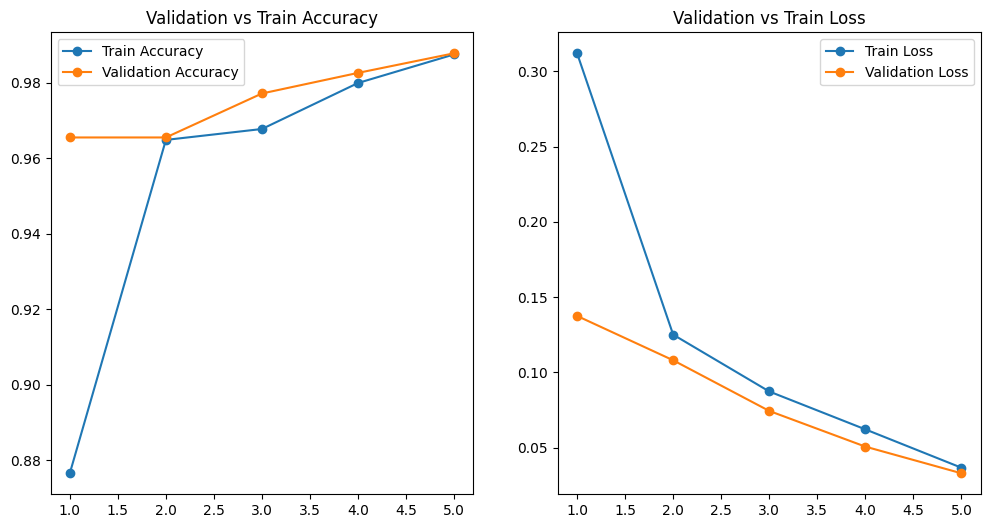

In [65]:
def plot_metrics():
  train_loss, train_acc, val_loss, val_acc = tuple(zip(*history))
  epochs = range(1, len(history) + 1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
  plt.plot(epochs, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
  plt.title('Validation vs Train Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Train Loss')
  plt.plot(epochs, val_loss, marker='o', linestyle='-', label='Validation Loss')
  plt.title('Validation vs Train Loss')
  plt.legend()
  plt.show()
plot_metrics() 

In [67]:
print(tokenizer.decode(X_train[example_index], skip_special_tokens=True))
tokenizer.decode(X_train[example_index][torch.flatten(torch.nonzero(y_train[example_index]))], skip_special_tokens=True)

Amfibol l. Amfibolit ( af Grek. amfibolos, tvetydig, oviss ), miner., en klass mineral af silikatens ordning, hvilka kristallisera i det monokliniska systemet och till sammansättningen äro bisilikat. Till denna klass höra strålsten, hornblende m. fl. — Orsaken till namnet var den svårighet man fordom hade att skilja detta mineral från det till utseende liknande mineralet augit. P


'Amfibol'

In [69]:
model.eval()
input_sentence = "Dungarpur [dangāpōə], vasallstat i Indien, sydligaste delen af Rajputana. 3,730 kvkm. 100,103 inv. (1901). Hufvudstaden, med samma namn, 6,094 inv., ligger 145 km. n. ö. om Ahmadabad."
encoded_input = tokenizer(input_sentence, return_tensors="pt", padding = "max_length", max_length = 100, truncation = True)['input_ids'].to(device)

with torch.no_grad():
    output_mask = model(encoded_input).argmax(dim=-1).view(-1).cpu()

headword = encoded_input.cpu().view(-1)[torch.flatten(torch.nonzero(output_mask))]
print("Predicted headword:", tokenizer.decode(headword, skip_special_tokens=True))

Predicted headword: Dungarpur
